In [17]:
import os
import random
import numpy as np

####*IMPORANT*: Have to do this line *before* importing tensorflow
seed = 812
os.environ['PYTHONHASHSEED']=str(seed)

def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)
    
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Layer, Reshape, Concatenate, Multiply, Average, Add

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
reset_random_seeds(seed)

In [18]:
# Task Name
task_name = " ACAN for polyps from endoscopic images" 

# Desired image dimensions
IMAGE_SIZE = (256, 256)

#List of categories, types & grades
labels = ['normal', 'abnormal']

#Autotune
AUTOTUNE = tf.data.AUTOTUNE

#Batch Size
BATCH_SIZE = 64

In [19]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each class")
    ax.set(xlabel="Classes", ylabel="#Images");
    ax.grid()

def load_data(polyp_folder, non_polyp_folder, image_size=(256, 256)):
    images = []
    labels = []  # 1 for polyp, 0 for non-polyp
    
    # Load polyp images
    for filename in os.listdir(polyp_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(polyp_folder, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(1)
    
    # Load non-polyp images
    for filename in os.listdir(non_polyp_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(non_polyp_folder, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(0)
    
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels)
    images = np.array(images)
    
    # combined = list(zip(images, labels))
    # random.shuffle(combined)
    # images, labels = zip(*combined)
    # images = np.array(images)
    # labels = np.array(labels)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", images.shape[0],
        ", with data shape", (images.shape[1], images.shape[2], images.shape[3]))
    
    return images, labels


In [20]:
image_size = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
data_polyp = "Data/abnormal"
data_non_polyp = "Data/normal"
data, labels = load_data(data_polyp, data_non_polyp)


Total number of uploaded data:  1070 , with data shape (256, 256, 3)


In [21]:
# Split the dataset into two subsets (80%-20%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2, stratify=labels)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_test = {X_train.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (856, 256, 256, 3)
y_train has shape: (856, 2)

X_test has shape: (214, 256, 256, 3)
y_test has shape: (214, 2)

X_train + X_test = 1070 samples in total


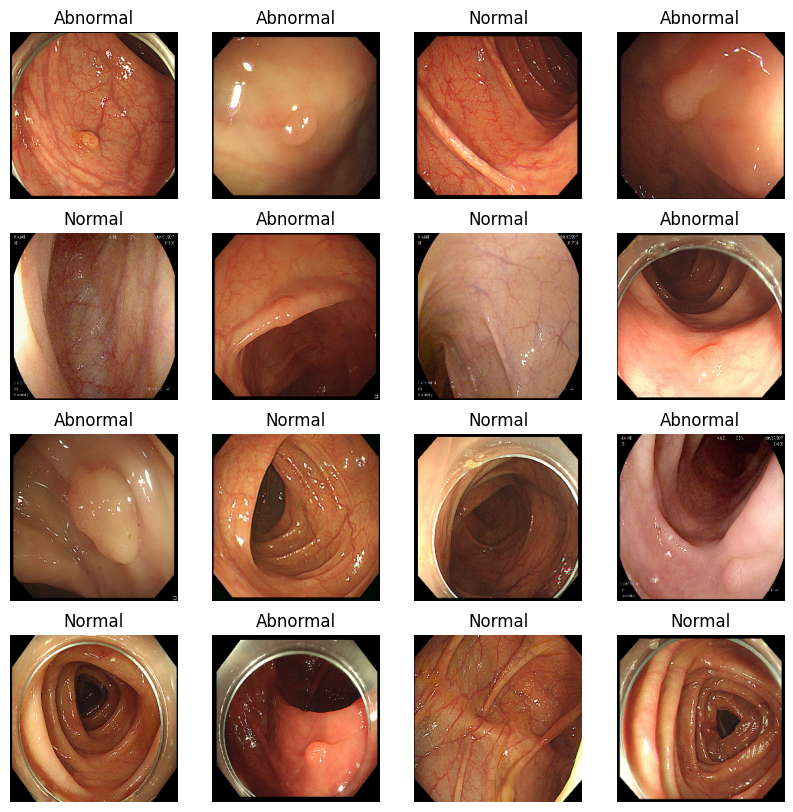

In [22]:
# Map the disease categories
mapping = {1:'Abnormal', 0:'Normal'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label[0])])
    plt.axis("off")

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Activation, Softmax, Multiply, Add

class DynamicContextualAttention(Layer):
    def __init__(self, filters, kernel_size, activation='relu', **kwargs):
        super(DynamicContextualAttention, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = Activation(activation)
        
    def build(self, input_shape):
        self.conv_layer = Conv2D(self.filters, self.kernel_size, padding='same')
        self.conv_activation = self.activation
        self.conv_softmax = Softmax(axis=[1, 2])
        
        # Additional layers for temporal attention
        self.temporal_conv = Conv2D(1, (1, 1), padding='same')
        self.temporal_softmax = Softmax(axis=-1)
        
        self.adaptive_conv = Conv2D(1, (1, 1), padding='same')
        self.adaptive_activation = Activation('sigmoid')
        
        super(DynamicContextualAttention, self).build(input_shape)
    
    def call(self, inputs):
        # Spatial attention
        spatial_features = self.conv_activation(self.conv_layer(inputs))
        spatial_attention = self.conv_softmax(spatial_features)
        
        # Temporal attention
        temporal_features = self.temporal_conv(inputs)
        temporal_attention = self.temporal_softmax(temporal_features)
        
        # Hierarchical fusion
        attention_weights = Multiply()([spatial_attention, temporal_attention])
        
        # Adaptive attention refinement
        adaptive_weights = self.adaptive_activation(self.adaptive_conv(inputs))
        refined_attention = Add()([attention_weights, adaptive_weights])
        
        # Multiply attention maps with input
        attended_inputs = Multiply()([refined_attention, inputs])
        
        return attended_inputs
    
    def compute_output_shape(self, input_shape):
        return input_shape  # Output shape same as input shape
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'activation': self.activation,
        })
        return config


In [25]:
def DCANModel(input_shape=(256, 256, 3), num_classes=2):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Base model (EfficientNetV2B0)
    base_model = EfficientNetV2B3(input_shape=input_shape, include_top=False, weights="imagenet")
    # We freeze our feature extractor
    base_model.trainable = True
    fmaps = base_model.output #base_model.get_layer('block4_pool').output
    dcan = DynamicContextualAttention(filters=fmaps.shape[-1], kernel_size=3)(fmaps)
    
    # Flatten layer
    gap = GlobalAveragePooling2D()(dcan)
    
    # Dense layer
    dense = Dense(64, activation='relu')(gap)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    # Model
    model = Model(inputs=base_model.inputs, outputs=outputs)
    return model

In [26]:

model = DCANModel(image_size)



In [32]:
EPOCHS = 100
batch_size = 16

filepath = "./saved_models/DCAN_polyp.keras"
os.makedirs("./saved_models", exist_ok=True)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Convert input data type to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop] #earlystopping

print(f"[INFO] training network for {EPOCHS} epochs...\n")

# Ensure labels are one-hot encoded for categorical crossentropy
# y_train = to_categorical(y_train, num_classes=2)
# y_test = to_categorical(y_test, num_classes=2)

hist = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test),epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100


In [16]:
print(y_train.shape)
print(y_test.shape)

(3424, 2)
(856, 2)
